In [1]:
import numpy as np
import os
import pulp
import pandas as pd

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import MultipleLocator

In [2]:
# process price data, select prices with label 1

hours = list(map(str, range(24))) 
prices_columns = list(map(str, range(24))) + ['label']
prices = pd.read_csv('./TestingResults.txt', names = prices_columns)
prices = prices.loc[prices['label']==1]
prices.pop('label')


           0         1         2         3         4         5         6  \
0   4.512853  3.436581  3.682556  3.062718  3.456278  4.028039  3.530470   
5   4.550190  3.605517  3.040928  3.653423  3.344234  3.163024  3.834255   
8   4.421347  3.683758  3.923207  3.070730  3.405958  3.375062  4.125457   
12  4.681636  3.359414  3.324270  3.474888  3.662299  3.235766  3.571356   
15  4.217611  3.524808  3.259288  3.213414  3.005478  4.093164  4.141625   
16  3.765169  3.428439  3.393895  2.887627  3.482510  4.028138  3.533672   
17  3.748322  3.522640  3.824900  3.729281  3.512599  3.206317  3.881053   
18  3.752677  3.348172  3.775181  3.186337  3.518939  3.230919  3.804398   
19  4.530964  3.564828  3.125315  2.974750  3.364015  3.457942  4.381639   
21  4.051403  3.557490  2.981983  3.016656  2.951125  3.940787  4.307193   
27  4.624424  3.755544  3.149902  3.464419  3.102661  3.098684  4.182672   
32  4.538901  3.714117  3.592581  2.828491  3.390930  3.235262  3.905072   
34  4.290940

In [3]:
# process user data, collect tasks

usertask = pd.read_csv('./UserTask.csv')
usertask.pop('Maximum scheduled energy per hour')


   User & Task ID  Ready Time  Deadline  Energy Demand
0     user1_task1          20        23              1
1     user1_task2          18        23              2
2     user1_task3          19        21              1
3     user1_task4          12        20              3
4     user1_task5           6        12              3
5     user1_task6          18        20              2
6     user1_task7           4        10              2
7     user1_task8          12        18              2
8     user1_task9           7        14              3
9    user1_task10           8        14              3
10    user2_task1          11        22              2
11    user2_task2           5        11              2
12    user2_task3           5        23              1
13    user2_task4           6        20              3
14    user2_task5          19        19              1
15    user2_task6          18        21              2
16    user2_task7           3        23              3
17    user

In [5]:
# construct lp problem for each user

for user_id in range(1,6):
    
    # lp_user1 = pulp.LpProblem("My_LP_Problem", pulp.LpMinimize)
    # ...
    # lp_user5 = pulp.LpProblem("My_LP_Problem", pulp.LpMinimize)
    exec("lp_user%s=pulp.LpProblem('My_LP_Problem', pulp.LpMinimize)"%user_id)


lp_user1
lp_user2
lp_user3
lp_user4
lp_user5


In [6]:
# construct decision variables 

task_by_hour = [[[]for j in range(24)] for i in range(5)]
task_by_id = [[[]for j in range(10)] for i in range(5)]

user_id = 1
task_id = 1

for task in usertask.itertuples():
    
    # construct decision variables for each task
    # if task1 of user1 starts from 20 to 23, then u1_t1_20, u1_t1_21, u1_t1_22 and u1_t1_23 will be crated
    for hour in range(task[2],task[3]+1):
        
        # u1_t1_20 = pulp.LpVariable('u1_t1_20', lowBound=0, upBound=1, cat='Continuous')
        # ...
        # u5_t10_23 = pulp.LpVariable('u5_t10_23', lowBound=0, upBound=1, cat='Continuous')
        exec("u%s_t%s_%s=pulp.LpVariable('u%s_t%s_%s', lowBound=0, upBound=1, cat='Continuous')"%(user_id,task_id,hour,user_id,task_id,hour))
        
        # store decision variables by hours
        exec("task_by_hour[%s][%s].append(u%s_t%s_%s)"%(user_id-1,hour,user_id,task_id,hour))
        
        # store decision variables by task id
        exec("task_by_id[%s][%s].append(u%s_t%s_%s)"%(user_id-1,task_id-1,user_id,task_id,hour))
        
    task_id += 1
    if task_id == 11:
        task_id = 1
        user_id += 1
        task


In [7]:
# construct constrain function

user_constrain = "0"
task_id = 1
user_id = 1

for task_energy in usertask['Energy Demand']:
    
    # construct constrain function for each task
    for task in task_by_id[user_id-1][task_id-1]:
        
        # add up all variables by current task id for current user
        exec("user_constrain += '+ %s'"%task)
    
    # construct constrain function (sum of variables of this task == energy demand of this task)
    exec("user_constrain += ' == %s'"%task_energy)
    
    # construct constrain function of current task for current user
    exec("lp_user%s += %s"%(user_id,user_constrain))
    
    task_id += 1
    if task_id == 11:
        task_id = 1
        user_id += 1
    user_constrain = "0"
    

In [8]:
# create folder

def mkdir(path): 
    import os
 
    path=path.strip()
    path=path.rstrip("\\")

    if not os.path.exists(path):
        os.makedirs(path)  
        return True

In [9]:
# plot scheduling results

def plot_schedule(energy_usage,plt_name):
    
    energy_usage.append(0)
    
    # set coordinate label
    plt.xlabel('Time (H)')
    plt.ylabel('Total Power (KW)')
    
    # set x-coordinate scale label
    hour_list = list(map(int, range(25)))
    
    # set dpi and size of figure
    plt.figure(dpi = 300, figsize = (15,10))

    # set y-coordinate to int
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # set y-coordinate interval to 1
    plt.gca().yaxis.set_major_locator(MultipleLocator(1))

    # draw bar chart
    plt.bar(range(25), energy_usage, width = 1,align = 'edge',linewidth = 1,edgecolor = 'black' , tick_label = hour_list)

    
    # save the bar chart
    mkdir('./charts_for_abnormal_prices/')
    plt.savefig('./charts_for_abnormal_prices/energy_usage(guideline%s).jpg' % plt_name)   
    plt.close()



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/reol/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zy/j2jkps316bzfk9v5fvqrr8rm0000gn/T/bf3fb768cab643028b146119200e675c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zy/j2jkps316bzfk9v5fvqrr8rm0000gn/T/bf3fb768cab643028b146119200e675c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 138 RHS
At line 149 BOUNDS
At line 211 ENDATA
Problem MODEL has 10 rows, 61 columns and 61 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-2) rows, 54 (-7) columns and 54 (-7) elements
0  Obj 10.247654 Primal inf 19.999992 (8)
8  Obj 100.87087
Optimal - objective value 100.87087
After Postsolve, objective 100.87087, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 100.8708686 - 8 iterations time 0.002, Pr

/Users/reol/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pulp/pulp.py:1704: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/reol/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zy/j2jkps316bzfk9v5fvqrr8rm0000gn/T/7acf2fe1ab04470fa50c208c9576b702-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zy/j2jkps316bzfk9v5fvqrr8rm0000gn/T/7acf2fe1ab04470fa50c208c9576b702-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 138 RHS
At line 149 BOUNDS
At line 211 ENDATA
Problem MODEL has 10 rows, 61 columns and 61 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-2) rows, 54 (-7) columns and 54 (-7) elements
0  Obj 10.296194 Primal inf 19.999992 (8)
8  Obj 100.97748
Optimal - objective value 100.97748
After Postsolve, objective 100.97748, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 100.9774757 - 8 iterations time 0.002, Pr

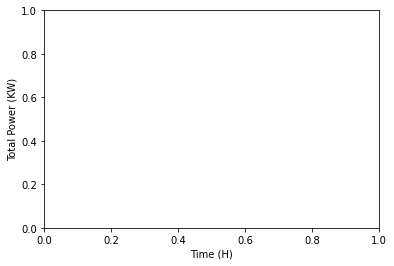

In [10]:
# construct objective function and do calculation

tasklist = "0"
user_function = "0"
energy_usage = [0]*24

for price in prices.itertuples():
    
    for user_id in range(1,6):
        
        for hour in range(0,24):
            
            for task in task_by_hour[user_id-1][hour]:
                
                # add up variables in current hour for current user 
                exec("tasklist += '+ %s'"%task)
            
            # add up (price * sum of variables) of each hour for current user, to construct objective function
            exec("user_function += '+ (%s) * %s'"%(tasklist,price[hour+1]))
            
            # reset the sum of variables of current hour
            tasklist = "0"
       
        # construct objective function for current user using current price guideline 
        exec("lp_user%s += %s"%(user_id,user_function))
        
        # reset objective function
        user_function = "0"
        
        # calculate scheduling results for current user using current price guideline 
        exec("lp_user%s.solve()"%user_id)
        
        # add up scheduling results of current user by hours
        for hour in range(0,24):
            for task in task_by_hour[user_id-1][hour]:
                energy_usage[hour] += task.varValue
    
    # plot sum of scheduling results of all 5 users by hours using current price guideline
    plot_schedule(energy_usage,price[0])
    energy_usage = [0]*24


